# 03 - Data Preparation - Features Creation
* (1) Create feature file in a DataFrame and save to parquet and csv formats
    * (1a) Main scripts for converting single subject data to a df_acc file
    * (1b) Show statistic of the features file for the first subject
    * (1c) Quality check with each type of activity from the 'df_acc' file 
      
* Here I will only show a simple version of features file, that includes:
    * Row: 'subject_id', 'device_loc', 'act_id', 'act_name', 'event_num', 'walk_or_not', 'unique_id', 'time', 'acc_x', 'acc_y', 'acc_z', 'fea_1', 'fea_2', ..., 'fea_1_norm', 'fea_2_norm', 'fea_3_norm', ... 
      - For Activity, it will include the following activity as True Positive and True Negative events:
        - True Positive (Walking): 1=walking; 2=descending stairs; 3=ascending stairs; 
        - True Negative (Non-Walking): 4=driving; 77=clapping; 99=non-study activity
    * The default data length for eash event will be 6-sec and shifting for 3-sec (50% of overlapping between each event) for the next event

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from constants import Constants

In [3]:
'''
Load functions and default setting variables by using *utils.py* and *constants.py* files
'''
# Get a list of all accelerometer files
all_files = utils.get_all_files()

# Setup paramters
fs = Constants.fs

In [4]:
# Load one accelerometer data file into dataframe
load_id = 0     # Load the first CSV file from the file list 
file_id, df = utils.load_single_data(all_files, load_id)
subject_id = file_id.split('/')[-1].split('.')[0]

In [5]:
'''
(1) Create feature file in a DataFrame and save to parquet and csv formats
    (1a) Main scripts for converting single subject data to a df_acc file 
'''

print('Begin to convert acc dataframe for Subject='+file_id)

# General setting
location_id = ['la']
win_length = 6  # default will be 10-sec for each event
win_shift = 3  # No overlapping between each event 
acc_inputs = ['la_x', 'la_y', 'la_z']   # Only select Left-Ankle for now
activities = [1, 2, 3, 4, 77, 99]       # All 6 activities with annotations
activities_TP = [1, 2, 3]               # 1=walking; 2=descending stairs; 3=ascending stairs;
activities_TN = [4, 77, 99]             # 4=driving; 77=clapping; 99=non-study activity;

# Create an empty dataframe with defaulted column names 
columns_features = ['subject_id', 'device_loc', 'act_id', 'act_name', 'event_num', 'walk_or_not', 'unique_id', 'time', 'acc_x', 'acc_y', 'acc_z']
df_fea_all = pd.DataFrame(columns=columns_features)

device_loc = utils.get_device_location_for_df(location_id[0])

for activity in activities:
    # create a temporal dataframe 
    df_fea_layer_1 = pd.DataFrame(columns=columns_features)
    
    df_act = df[df.activity==activity]
    act_id = activity
    act_name = utils.get_activity_type_for_df(activity)

    # Begin to cut data into several 10-sec events
    total_segments_sec = round( (df_act.time_s.iloc[-1]-df_act.time_s.iloc[0]) / ( win_length-(win_length-win_shift) ) )  # compute how many segmnets in second will be cut
    for count, num in enumerate(range(0, total_segments_sec), start=1):
        df_fea_layer_2 = pd.DataFrame(columns=columns_features)
        
        cut_begin = df_act.time_s.iloc[0] + num*win_length
        cut_end   = cut_begin + win_length 
        df_cut_tmp = df_act[(df_act.time_s>=cut_begin) & (df_act.time_s<=cut_end)]
        
        # Write values into a temporal feature dataframe
        if df_cut_tmp.empty:
            df_fea_layer_2 = pd.DataFrame(columns=columns_features)  # If no values within the cut datafrmae
        else:
            if (df_cut_tmp.time_s.iloc[-1]-df_cut_tmp.time_s.iloc[0]) < win_length*0.9: 
                # apply quality control to make sure the segment does not include missing data
                # If the segment length is less than 90% of the target time window (9 sec in this case), discard this segment. 
                df_fea_layer_2 = pd.DataFrame(columns=columns_features)
            else:
                # Write the cut dataframe into a temporal feature dataframe
                df_fea_layer_2['time'] = df_cut_tmp['time_s']
                df_fea_layer_2['acc_x'] = df_cut_tmp['la_x']
                df_fea_layer_2['acc_y'] = df_cut_tmp['la_y']
                df_fea_layer_2['acc_z'] = df_cut_tmp['la_z']
        
                # Write others values into the temporal feature dataframe 
                df_fea_layer_2['subject_id'] = subject_id
                df_fea_layer_2['device_loc'] = device_loc
                df_fea_layer_2['act_id'] = act_id
                df_fea_layer_2['act_name'] = act_name
                df_fea_layer_2['event_num'] = count

                unique_id_template = subject_id+'_'+device_loc+'_'+str(activity)+'_'+act_name+'_'+str(count)
                if activity in activities_TP:
                    df_fea_layer_2['walk_or_not'] = 1
                    df_fea_layer_2['unique_id'] = unique_id_template + '_1'
                elif activity in activities_TN:
                    df_fea_layer_2['walk_or_not'] = 0
                    df_fea_layer_2['unique_id'] = unique_id_template + '_0'
                
        # Reset dataframe index
        df_fea_layer_2 = df_fea_layer_2.reset_index(drop=True)

        # Concat each 10-sec dataframe into a larger dataframe
        df_fea_layer_1 = pd.concat([df_fea_layer_1, df_fea_layer_2])
        df_fea_layer_1 = df_fea_layer_1.reset_index(drop=True)
        
    # Concat all dataframes into one big final dataframe
    df_fea_all = pd.concat([df_fea_all, df_fea_layer_1])
    df_fea_all = df_fea_all.reset_index(drop=True)    

# # Save the output dataframe to a parquet format (to save up to 90% of space)
df_fea_all.to_parquet('../outputs/df_acc_la_'+subject_id+'.parquet')
df_fea_all.to_csv('../outputs/df_acc_la_'+subject_id+'.csv')
print('Completed converting')

Begin to convert acc dataframe for Subject=../data/raw_accelerometry_data/idf1ce9a0f.csv
Completed converting


In [6]:
'''
Re-load the saved parquet df_acc file
'''
df = pd.read_parquet('../outputs/df_acc_la_idf1ce9a0f.parquet')
print(np.unique(df.act_name))
df

['AscendStairs' 'DescStairs' 'Driving' 'NonStudyAct' 'Walking']


,subject_id,device_loc,act_id,act_name,event_num,walk_or_not,unique_id,time,acc_x,acc_y,acc_z
0,idf1ce9a0f,AnkleL,1,Walking,1,1,idf1ce9a0f_AnkleL_1_Walking_1_1,354.05,-0.070,-0.973,0.078
1,idf1ce9a0f,AnkleL,1,Walking,1,1,idf1ce9a0f_AnkleL_1_Walking_1_1,354.06,-0.082,-0.965,0.094
2,idf1ce9a0f,AnkleL,1,Walking,1,1,idf1ce9a0f_AnkleL_1_Walking_1_1,354.07,-0.082,-0.969,0.086
3,idf1ce9a0f,AnkleL,1,Walking,1,1,idf1ce9a0f_AnkleL_1_Walking_1_1,354.08,-0.082,-0.973,0.086
4,idf1ce9a0f,AnkleL,1,Walking,1,1,idf1ce9a0f_AnkleL_1_Walking_1_1,354.09,-0.098,-0.969,0.105
...,...,...,...,...,...,...,...,...,...,...,...
315181,idf1ce9a0f,AnkleL,99,NonStudyAct,547,0,idf1ce9a0f_AnkleL_99_NonStudyAct_547_0,3281.97,-0.055,0.039,0.996
315182,idf1ce9a0f,AnkleL,99,NonStudyAct,547,0,idf1ce9a0f_AnkleL_99_NonStudyAct_547_0,3281.98,-0.055,0.039,0.992
315183,idf1ce9a0f,AnkleL,99,NonStudyAct,547,0,idf1ce9a0f_AnkleL_99_NonStudyAct_547_0,3281.99,-0.059,0.035,0.988
315184,idf1ce9a0f,AnkleL,99,NonStudyAct,547,0,idf1ce9a0f_AnkleL_99_NonStudyAct_547_0,3282.00,-0.063,0.039,0.992


Subject id=idf1ce9a0f
Total Walking events= 98
Total Non-Walking events= 427
Non-Walking/Walking Ratio= 4.357142857142857


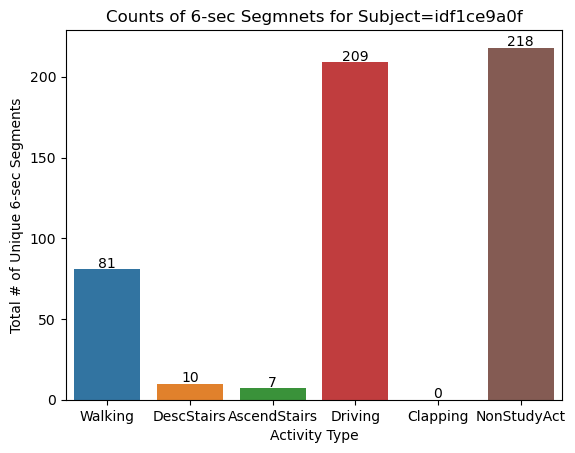

In [7]:
'''
(1b) Show statistic of the features file for the first subject
'''
total_events = len(np.unique(df.unique_id))

total_Walking = len(np.unique(df[df.act_id==1].unique_id))
total_DescStairs = len(np.unique(df[df.act_id==2].unique_id))
total_AscendStairs = len(np.unique(df[df.act_id==3].unique_id))
total_Driving = len(np.unique(df[df.act_id==4].unique_id))
total_Clapping = len(np.unique(df[df.act_id==77].unique_id))
total_NonStudyAct = len(np.unique(df[df.act_id==99].unique_id))

act_type = ['Walking', 'DescStairs', 'AscendStairs', 'Driving', 'Clapping', 'NonStudyAct']
total_num = [total_Walking, total_DescStairs, total_AscendStairs, total_Driving, total_Clapping, total_NonStudyAct]

sns.barplot(x=act_type, y=total_num)
plt.xlabel('Activity Type')
plt.ylabel('Total # of Unique 6-sec Segments')
plt.title('Counts of 6-sec Segmnets for Subject='+subject_id)

for i in range(len(act_type)):
    plt.text(x=i, y=total_num[i] + 1, s=total_num[i], ha='center')

print("Subject id="+subject_id)
print("Total Walking events=", (total_Walking+total_DescStairs+total_AscendStairs))
print("Total Non-Walking events=", (total_Driving+total_Clapping+total_NonStudyAct))
print("Non-Walking/Walking Ratio=", (total_Driving+total_Clapping+total_NonStudyAct)/(total_Walking+total_DescStairs+total_AscendStairs))

Text(0.5, 1.0, 'Non-Study Activity (99) / 6-sec')

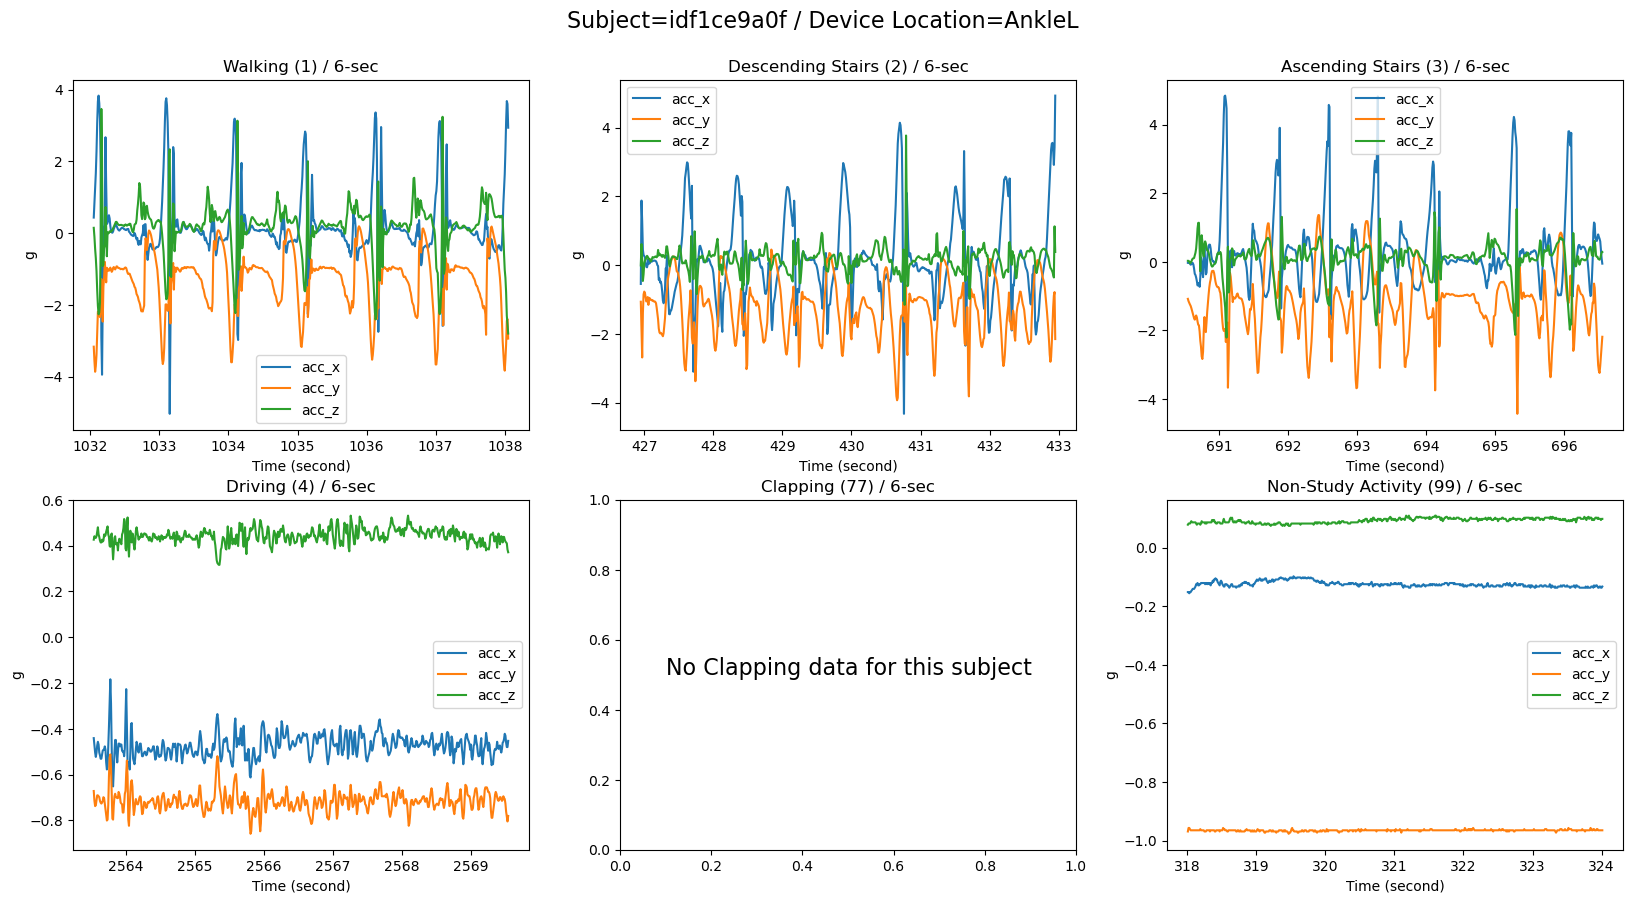

In [8]:
'''
(1c) Quality check with each type of activity from the 'df_acc' file 
'''

fig = plt.figure(figsize=(20, 10))

fig.suptitle('Subject='+df.subject_id.iloc[0]+' / Device Location='+df.device_loc.iloc[0], fontsize=16, y=0.95)

def _plot(df2):
    plt.plot(df2.time, df2.acc_x, label='acc_x')
    plt.plot(df2.time, df2.acc_y, label='acc_y')
    plt.plot(df2.time, df2.acc_z, label='acc_z')
    plt.legend()
    plt.xlabel('Time (second)')
    plt.ylabel('g')

plt.subplot(2,3,1)
df2 = df[(df.unique_id=='idf1ce9a0f_AnkleL_1_Walking_114_1')]
_plot(df2)
plt.title('Walking (1) / 6-sec')

plt.subplot(2,3,2)
df2 = df[(df.unique_id=='idf1ce9a0f_AnkleL_2_DescStairs_6_1')]
_plot(df2)
plt.title('Descending Stairs (2) / 6-sec')

plt.subplot(2,3,3)
df2 = df[(df.unique_id=='idf1ce9a0f_AnkleL_3_AscendStairs_48_1')]
_plot(df2)
plt.title('Ascending Stairs (3) / 6-sec')


plt.subplot(2,3,4)
df2 = df[(df.unique_id=='idf1ce9a0f_AnkleL_4_Driving_198_0')]
_plot(df2)
plt.title('Driving (4) / 6-sec')


plt.subplot(2,3,5)
plt.text(0.1, 0.5, 'No Clapping data for this subject', fontsize=16)
plt.title('Clapping (77) / 6-sec')

plt.subplot(2,3,6)
df2 = df[(df.unique_id=='idf1ce9a0f_AnkleL_99_NonStudyAct_54_0')]
_plot(df2)
plt.title('Non-Study Activity (99) / 6-sec')

In [9]:
'''
(2a) Compute features and obtain a dataframe for singel 6-sec event
'''

all_unique_events = np.unique(df.unique_id)

df_event = df[df.unique_id==all_unique_events[0]]  # Cut dataframe into single event

# Create an empty dataframe with defaulted column names 
columns_features = ['subject_id', 'device_loc', 'act_id', 'act_name', 'event_num', 'walk_or_not', 'unique_id', 'time', 'acc_x', 'acc_y', 'acc_z', 'smv']

input_data = ['acc_x', 'acc_y', 'acc_z', 'smv']   # Input time series for computing features
features_types = ['mean', 'std', 'min', 'max']    # Features list to compute
features_names_for_df = ['fea_' + input_item + '_' + feature for input_item in input_data for feature in features_types]  # feature names used in a new dataframe 

columns_added_features = columns_features + features_names_for_df
df_fea_all = pd.DataFrame(columns=columns_features)

def _smv(x, y, z):
    '''
    Compute Signal Mangitude Vector from 3-axis acc data
    '''
    return np.sqrt((x*x) + (y*y) + (z*z))

t = df_event['time']
acc_x = df_event['acc_x']
acc_y = df_event['acc_y']
acc_z = df_event['acc_z']

# Samples quality check: interpolate any null-valued samples
acc_x = utils._interpolate(acc_x)
acc_y = utils._interpolate(acc_y)
acc_z = utils._interpolate(acc_z)

smv = _smv(acc_x, acc_y, acc_z)
df_event = df_event.copy()
df_event.loc[:, 'smv'] = smv 

# Begin computing features
for input_cmp in input_data:
    data = df_event[input_cmp]
    for fea_type in features_types:
        if fea_type == 'mean':
            df_event = df_event.copy()
            df_event.loc[:, 'fea_'+input_cmp+'_'+fea_type] = np.mean(data)
        elif fea_type == 'std':
            df_event = df_event.copy()
            df_event.loc[:, 'fea_'+input_cmp+'_'+fea_type] = np.std(data)
        elif fea_type == 'min':
            df_event = df_event.copy()
            df_event.loc[:, 'fea_'+input_cmp+'_'+fea_type] = np.min(data)                
        elif fea_type == 'max':
            df_event = df_event.copy()
            df_event.loc[:, 'fea_'+input_cmp+'_'+fea_type] = np.max(data)        

df_event

,subject_id,device_loc,act_id,act_name,event_num,walk_or_not,unique_id,time,acc_x,acc_y,...,fea_acc_y_min,fea_acc_y_max,fea_acc_z_mean,fea_acc_z_std,fea_acc_z_min,fea_acc_z_max,fea_smv_mean,fea_smv_std,fea_smv_min,fea_smv_max
43272,idf1ce9a0f,AnkleL,1,Walking,107,1,idf1ce9a0f_AnkleL_1_Walking_107_1,990.05,-0.117,-0.199,...,-3.977,0.125,0.184679,0.761409,-2.953,3.352,1.71959,1.157869,0.347406,5.543605
43273,idf1ce9a0f,AnkleL,1,Walking,107,1,idf1ce9a0f_AnkleL_1_Walking_107_1,990.06,-0.113,-0.270,...,-3.977,0.125,0.184679,0.761409,-2.953,3.352,1.71959,1.157869,0.347406,5.543605
43274,idf1ce9a0f,AnkleL,1,Walking,107,1,idf1ce9a0f_AnkleL_1_Walking_107_1,990.07,-0.074,-0.324,...,-3.977,0.125,0.184679,0.761409,-2.953,3.352,1.71959,1.157869,0.347406,5.543605
43275,idf1ce9a0f,AnkleL,1,Walking,107,1,idf1ce9a0f_AnkleL_1_Walking_107_1,990.08,-0.051,-0.406,...,-3.977,0.125,0.184679,0.761409,-2.953,3.352,1.71959,1.157869,0.347406,5.543605
43276,idf1ce9a0f,AnkleL,1,Walking,107,1,idf1ce9a0f_AnkleL_1_Walking_107_1,990.09,0.012,-0.504,...,-3.977,0.125,0.184679,0.761409,-2.953,3.352,1.71959,1.157869,0.347406,5.543605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43868,idf1ce9a0f,AnkleL,1,Walking,107,1,idf1ce9a0f_AnkleL_1_Walking_107_1,996.01,3.750,-2.840,...,-3.977,0.125,0.184679,0.761409,-2.953,3.352,1.71959,1.157869,0.347406,5.543605
43869,idf1ce9a0f,AnkleL,1,Walking,107,1,idf1ce9a0f_AnkleL_1_Walking_107_1,996.02,3.848,-2.254,...,-3.977,0.125,0.184679,0.761409,-2.953,3.352,1.71959,1.157869,0.347406,5.543605
43870,idf1ce9a0f,AnkleL,1,Walking,107,1,idf1ce9a0f_AnkleL_1_Walking_107_1,996.03,3.668,-2.277,...,-3.977,0.125,0.184679,0.761409,-2.953,3.352,1.71959,1.157869,0.347406,5.543605
43871,idf1ce9a0f,AnkleL,1,Walking,107,1,idf1ce9a0f_AnkleL_1_Walking_107_1,996.04,3.422,-2.316,...,-3.977,0.125,0.184679,0.761409,-2.953,3.352,1.71959,1.157869,0.347406,5.543605


In [10]:
'''
(2b) Run loops to compute features dataframe all 6-sec event for a single subject
'''

# Load existing df_acc file
df = pd.read_parquet('../outputs/df_acc_la_idf1ce9a0f.parquet')


# Create a new dataframe to include features
columns_features = ['subject_id', 'device_loc', 'act_id', 'act_name', 'event_num', 'walk_or_not', 'unique_id', 'time', 'acc_x', 'acc_y', 'acc_z', 'smv']
input_data = ['acc_x', 'acc_y', 'acc_z', 'smv']   # Input time series for computing features
features_types = ['mean', 'std', 'min', 'max']    # Features list to compute
features_names_for_df = ['fea_' + input_item + '_' + feature for input_item in input_data for feature in features_types]  # feature names used in a new dataframe 
columns_added_features = columns_features + features_names_for_df
df_fea_all = pd.DataFrame(columns=columns_features)


def compute_features(df_event):
    
    def _smv(x, y, z):
        '''
        Compute Signal Mangitude Vector from 3-axis acc data
        '''
        return np.sqrt((x*x) + (y*y) + (z*z))
    
    t = df_event['time']
    acc_x = df_event['acc_x']
    acc_y = df_event['acc_y']
    acc_z = df_event['acc_z']
    
    # Samples quality check: interpolate any null-valued samples
    acc_x = utils._interpolate(acc_x)
    acc_y = utils._interpolate(acc_y)
    acc_z = utils._interpolate(acc_z)
    
    smv = _smv(acc_x, acc_y, acc_z)
    df_event = df_event.copy()
    df_event.loc[:, 'smv'] = smv 
    
    # Begin computing features
    for input_cmp in input_data:
        data = df_event[input_cmp]
        for fea_type in features_types:
            if fea_type == 'mean':
                df_event = df_event.copy()
                df_event.loc[:, 'fea_'+input_cmp+'_'+fea_type] = np.mean(data)
            elif fea_type == 'std':
                df_event = df_event.copy()
                df_event.loc[:, 'fea_'+input_cmp+'_'+fea_type] = np.std(data)
            elif fea_type == 'min':
                df_event = df_event.copy()
                df_event.loc[:, 'fea_'+input_cmp+'_'+fea_type] = np.min(data)                
            elif fea_type == 'max':
                df_event = df_event.copy()
                df_event.loc[:, 'fea_'+input_cmp+'_'+fea_type] = np.max(data)    
                
    return df_event


# Begin to compute features for all event
all_unique_events = np.unique(df.unique_id)

for event in all_unique_events:
    df_event = df[df.unique_id==event]  # Cut dataframe into single event

    # Compute features
    df_event = compute_features(df_event)

    # Concat each event into a larger dataframe
    df_fea_all = pd.concat([df_fea_all, df_event])
    df_fea_all = df_fea_all.reset_index(drop=True)

In [11]:
# Save the df_fea file to a parquet format (to save up to 90% of space)
df_fea_all.to_parquet('../outputs/df_fea_la_'+subject_id+'.parquet')
df_fea_all.to_csv('../outputs/df_fea_la_'+subject_id+'.csv')
print('Completed converting')

Completed converting


In [14]:
df_fea_all

,subject_id,device_loc,act_id,act_name,event_num,walk_or_not,unique_id,time,acc_x,acc_y,...,fea_acc_y_min,fea_acc_y_max,fea_acc_z_mean,fea_acc_z_std,fea_acc_z_min,fea_acc_z_max,fea_smv_mean,fea_smv_std,fea_smv_min,fea_smv_max
0,idf1ce9a0f,AnkleL,1,Walking,107,1,idf1ce9a0f_AnkleL_1_Walking_107_1,990.05,-0.117,-0.199,...,-3.977,0.125,0.184679,0.761409,-2.953,3.352,1.719590,1.157869,0.347406,5.543605
1,idf1ce9a0f,AnkleL,1,Walking,107,1,idf1ce9a0f_AnkleL_1_Walking_107_1,990.06,-0.113,-0.270,...,-3.977,0.125,0.184679,0.761409,-2.953,3.352,1.719590,1.157869,0.347406,5.543605
2,idf1ce9a0f,AnkleL,1,Walking,107,1,idf1ce9a0f_AnkleL_1_Walking_107_1,990.07,-0.074,-0.324,...,-3.977,0.125,0.184679,0.761409,-2.953,3.352,1.719590,1.157869,0.347406,5.543605
3,idf1ce9a0f,AnkleL,1,Walking,107,1,idf1ce9a0f_AnkleL_1_Walking_107_1,990.08,-0.051,-0.406,...,-3.977,0.125,0.184679,0.761409,-2.953,3.352,1.719590,1.157869,0.347406,5.543605
4,idf1ce9a0f,AnkleL,1,Walking,107,1,idf1ce9a0f_AnkleL_1_Walking_107_1,990.09,0.012,-0.504,...,-3.977,0.125,0.184679,0.761409,-2.953,3.352,1.719590,1.157869,0.347406,5.543605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315181,idf1ce9a0f,AnkleL,99,NonStudyAct,9,0,idf1ce9a0f_AnkleL_99_NonStudyAct_9_0,53.97,2.047,-1.352,...,-2.242,-0.215,0.094879,0.169576,-0.902,0.723,1.102567,0.338263,0.373766,2.457007
315182,idf1ce9a0f,AnkleL,99,NonStudyAct,9,0,idf1ce9a0f_AnkleL_99_NonStudyAct_9_0,53.98,1.965,-1.371,...,-2.242,-0.215,0.094879,0.169576,-0.902,0.723,1.102567,0.338263,0.373766,2.457007
315183,idf1ce9a0f,AnkleL,99,NonStudyAct,9,0,idf1ce9a0f_AnkleL_99_NonStudyAct_9_0,53.99,1.789,-1.422,...,-2.242,-0.215,0.094879,0.169576,-0.902,0.723,1.102567,0.338263,0.373766,2.457007
315184,idf1ce9a0f,AnkleL,99,NonStudyAct,9,0,idf1ce9a0f_AnkleL_99_NonStudyAct_9_0,54.00,1.590,-1.453,...,-2.242,-0.215,0.094879,0.169576,-0.902,0.723,1.102567,0.338263,0.373766,2.457007


In [52]:
# Show all unique_event_id
all_unique_events

array(['idf1ce9a0f_AnkleL_1_Walking_107_1',
       'idf1ce9a0f_AnkleL_1_Walking_108_1',
       'idf1ce9a0f_AnkleL_1_Walking_109_1',
       'idf1ce9a0f_AnkleL_1_Walking_110_1',
       'idf1ce9a0f_AnkleL_1_Walking_111_1',
       'idf1ce9a0f_AnkleL_1_Walking_112_1',
       'idf1ce9a0f_AnkleL_1_Walking_113_1',
       'idf1ce9a0f_AnkleL_1_Walking_114_1',
       'idf1ce9a0f_AnkleL_1_Walking_115_1',
       'idf1ce9a0f_AnkleL_1_Walking_15_1',
       'idf1ce9a0f_AnkleL_1_Walking_16_1',
       'idf1ce9a0f_AnkleL_1_Walking_17_1',
       'idf1ce9a0f_AnkleL_1_Walking_18_1',
       'idf1ce9a0f_AnkleL_1_Walking_19_1',
       'idf1ce9a0f_AnkleL_1_Walking_1_1',
       'idf1ce9a0f_AnkleL_1_Walking_20_1',
       'idf1ce9a0f_AnkleL_1_Walking_21_1',
       'idf1ce9a0f_AnkleL_1_Walking_22_1',
       'idf1ce9a0f_AnkleL_1_Walking_23_1',
       'idf1ce9a0f_AnkleL_1_Walking_24_1',
       'idf1ce9a0f_AnkleL_1_Walking_25_1',
       'idf1ce9a0f_AnkleL_1_Walking_26_1',
       'idf1ce9a0f_AnkleL_1_Walking_27_1',
   